# 1. Data Preparation

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

In [41]:
# load data
filepath = "Project_data.csv"
df = pd.read_csv(filepath)
# getting "time" axis using "year" and "month" column
df["month"].unique()


array(['FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'DEC',
       'JAN', 'OCT', 'NOV'], dtype=object)

In [42]:
def convert_time(year, month):
    month_dict = {"JAN": 1,
                  "FEB": 2,
                  "MAR": 3,
                  "APR": 4,
                  "MAY": 5,
                  "JUN": 6,
                  "JUL": 7,
                  "AUG": 8,
                  "SEP": 9,
                  "OCT": 10,
                  "NOV": 11,
                  "DEC": 12
                 }
    time_unit = year * 12 + month_dict[month]
    return time_unit

In [43]:
df["time"] = df.apply(lambda row : convert_time(row['year'], row['month']), axis = 1)

In [44]:
df

,API,year,month,oil,time
0,A_30015420120000,2015,FEB,0,24182
1,A_30015420120000,2015,MAR,5329,24183
2,A_30015420120000,2015,APR,2996,24184
3,A_30015420120000,2015,MAY,2369,24185
4,A_30015420120000,2015,JUN,1957,24186
...,...,...,...,...,...
3019,A_30015424970000,2018,JAN,1976,24217
3020,A_30015424970000,2018,FEB,1650,24218
3021,A_30015424970000,2018,MAR,1964,24219
3022,A_30015424970000,2018,APR,1437,24220


In [45]:
# group by well name "API"
df_grouped = df.groupby("API")

In [46]:
wells = df['API'].unique()

In [47]:
# confirm that the file contains data for 100 wells
wells.shape[0]

100

In [48]:
# find out the wells that have fewer than 5 data points
dropped = []
for well_name in wells:
    if df_grouped.get_group(well_name).shape[0] <= 5:
        dropped.append(well_name)
        print(well_name + " has fewer than 5 data points")
# drop these wells from the wells list
well_list = wells.tolist()
for well_few in dropped:
    well_list.remove(well_few)

A_30015422820000 has fewer than 5 data points


In [49]:
model_data = []

In [50]:
# finally transform the time unit for each well according to the project requirement 
# i.e. every well starts producing oil from the time 0
for well_name in well_list:
    this_well = df_grouped.get_group(well_name).sort_values(by='time', ascending=True)
    minTime = min(this_well['time'])
    this_well['t'] = this_well['time'] - minTime
    model_data.append(this_well)
model_data = pd.concat(model_data, ignore_index=True)

In [51]:
# this is the data we need to fit
model_data

,API,year,month,oil,time,t
0,A_30015420120000,2015,FEB,0,24182,0
1,A_30015420120000,2015,MAR,5329,24183,1
2,A_30015420120000,2015,APR,2996,24184,2
3,A_30015420120000,2015,MAY,2369,24185,3
4,A_30015420120000,2015,JUN,1957,24186,4
...,...,...,...,...,...,...
3017,A_30015424970000,2018,JAN,1976,24217,36
3018,A_30015424970000,2018,FEB,1650,24218,37
3019,A_30015424970000,2018,MAR,1964,24219,38
3020,A_30015424970000,2018,APR,1437,24220,39


# 2. Prepare the fitting function

In [ ]:
from scipy.optimize import differential_evolution

def ackley(x):
    arg1 = -0.2 * np.sqrt(0.5 * (x[0] ** 2 + x[1] ** 2))
    arg2 = 0.5 * (np.cos(2. * np.pi * x[0]) + np.cos(2. * np.pi * x[1]))
    return -20. * np.exp(arg1) - np.exp(arg2) + 20. + np.e
bounds = [(-5, 5), (-5, 5)]
result = differential_evolution(ackley, bounds)
result.x, result.fun
(array([ 0.,  0.]), 4.4408920985006262e-16)

In [99]:
def fit_objective(x, data):
    """
    representing the decay part of production after the peak
    x[0]: q0
    x[1]: D0
    x[2]: b
    x[3]: D1
    x[4]: t1
    """
    q0 = x[0]
    D0 = x[1]
    b  = x[2]
    D1 = x[3]
    t1 = x[4]
    q1 = q0 * np.exp(D0 * t1)
    
    well_t = data[0,:]
    well_prod = data[1,:]
    
    sumLoss = 0
    for i in range(len(well_t)):
        if well_t[i] < t1:
            sumLoss += (q0 * np.exp(D0 * well_t[i]) - well_prod[i])**2.0
        else:
            sumLoss +=  (q1 / (1.0 + b * D1 * (well_t[i]-t1)**(1.0/b)) - well_prod[i])**2.0
    
    return sumLoss

# 3. Run the optimizer for each well and save the parameters

In [100]:
model_data_grouped = model_data.groupby('API')

In [143]:
from scipy.optimize import differential_evolution
import time


start = time.time()

# run the optimizer for each well
params = dict()
lossFitting = dict()
for well_name in well_list:
    well_data = model_data_grouped.get_group(well_name)[['t','oil']]
    t = np.asarray(well_data['t'].tolist())
    oil = np.asarray(well_data['oil'].tolist())
    test = np.stack((t, oil), axis=0)
    t_index = well_data[well_data['oil'] == max(well_data['oil'])]
    tmax = t_index['t'].tolist()[0]
    t1_bound = (tmax,tmax+1.0) # this should be between time of the max prod rate and its next time unit
    q0_bound = (0, max(well_data['oil']) * 2.0) # not so sure how to determine the max!!
    D0_bound = (0, 10) # not sure how to determine the upper bound!!
    b_bound  = (0, 10) # not sure how to determine the upper bound!!
    D1_bound = (0, max(well_data['oil'])) # represents the initial decline, so the max should be less than the max prod rate
    bounds = [q0_bound, D0_bound, b_bound, D1_bound, t1_bound]
    result = differential_evolution(fit_objective, bounds, args=(test,))
    params[well_name] = result.x
    lossFitting[well_name] = result.fun/len(t)

    
end = time.time()

# total time taken
print(f"Runtime of the program is {end - start}")


<ipython-input-99-83a1cd6ce870>:25: RuntimeWarning: overflow encountered in double_scalars
  sumLoss +=  (q1 / (1.0 + b * D1 * (well_t[i]-t1)**(1.0/b)) - well_prod[i])**2.0
<ipython-input-99-83a1cd6ce870>:25: RuntimeWarning: divide by zero encountered in double_scalars
  sumLoss +=  (q1 / (1.0 + b * D1 * (well_t[i]-t1)**(1.0/b)) - well_prod[i])**2.0
<ipython-input-99-83a1cd6ce870>:25: RuntimeWarning: invalid value encountered in double_scalars
  sumLoss +=  (q1 / (1.0 + b * D1 * (well_t[i]-t1)**(1.0/b)) - well_prod[i])**2.0


Runtime of the program is 111.8398609161377


# 4. Result Visualization

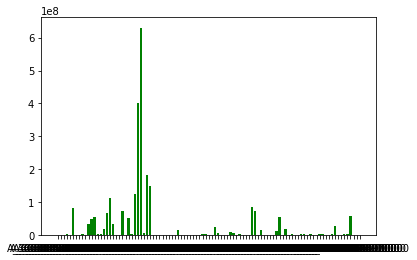

In [146]:
plt.bar(list(lossFitting.keys()), lossFitting.values(), color='g')
plt.show()

(array([88.,  7.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([1.43141342e+03, 6.30208138e+07, 1.26040196e+08, 1.89059579e+08,
        2.52078961e+08, 3.15098343e+08, 3.78117726e+08, 4.41137108e+08,
        5.04156491e+08, 5.67175873e+08, 6.30195256e+08]),
 <BarContainer object of 10 artists>)

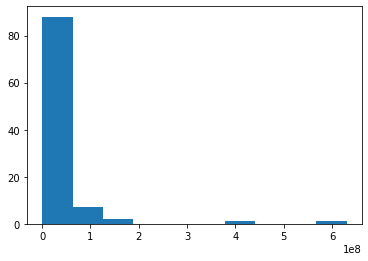

In [145]:
h = [v for v in lossFitting.values()]
plt.hist(h)

In [147]:
plot_wells = well_list[0:4]

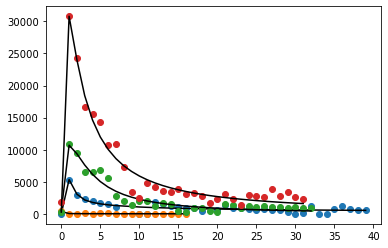

In [151]:

for well_name in plot_wells:
    well_data = model_data_grouped.get_group(well_name)[['t','oil']]
    t = np.asarray(well_data['t'].tolist())
    oil = np.asarray(well_data['oil'].tolist())
    x = params[well_name]
    q0 = x[0]
    D0 = x[1]
    b  = x[2]
    D1 = x[3]
    t1 = x[4]
    q1 = q0 * np.exp(D0 * t1)
    
    pred = []
    for i in range(len(t)):
        if t[i] < t1:
            pred.append(q0 * np.exp(D0 * t[i]))
        else:
            pred.append( q1 / (1.0 + b * D1 * (t[i]-t1)**(1.0/b)))
    predY = np.asarray(pred)
    
    plt.plot(t, oil, 'o', t, predY, 'k-')

    